## Import modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from dataclasses import dataclass
from tqdm import tqdm

### Helpers

#### Plot losses method

In [2]:
def plot_loss(losses_generator, losses_critic, title):
    """
    Plots the losses over the training iterations.

    Args:
        losses (list): List of loss values.
        title (str): The title of the plot.

    Returns:
        None
    """
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.plot(losses_generator, label="Generator")
    plt.plot(losses_critic, label="Critic")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.show()


#### Generate images method

In [3]:
def generate_images(generator, label, n_images=16, device='cuda', config=None):
    """
    Generates and displays fake images using a generator model.

    Parameters:
    - generator (torch.nn.Module): The generator model used to generate fake images.
    - label (int): The label to be assigned to the generated images.
    - n_images (int): The number of fake images to generate and display. Default is 16.
    - device (str): The device to use for generating the images. Default is 'cuda'.
    - config (object): Additional configuration options. Default is None.

    Returns:
    None
    """
    z = torch.randn(n_images, config.noise_dim, device=device)
    labels = torch.full((n_images,), label, dtype=torch.long, device=device)
    
    try:
        with torch.no_grad():
            fake_images = generator(z, labels).view(-1, 28, 28).cpu().numpy()
    except TypeError:
        with torch.no_grad():
            fake_images = generator(z).view(-1, 28, 28).cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(n_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(fake_images[i], cmap='gray')
        plt.axis('off')
    plt.show()


## Define a config dataclass

In [4]:
@dataclass
class Config:
    """
    Configuration class for the GAN model.

    Attributes:
        batch_size (int): The batch size for training.
        lr (float): The learning rate for the model.
        num_epochs (int): The number of epochs for training.
        noise_dim (int): The dimension of the noise for the generator.
        clip_value (float): The value used for weight clipping in WGAN.
        critic_iter (int): The number of iterations to train the critic for each generator iteration.
    """
    batch_size: int = 64
    lr: float = 0.00005
    num_epochs: int = 100
    noise_dim: int = 100
    clip_value: float = 0.01
    critic_iter: int = 5

config = Config()

## Load the dataset and define a train dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

## GAN

### Define a Critic class

In [6]:
class Critic(nn.Module):
    def __init__(self):
        """
        Critic class represents the critic network in a GAN model.

        The critic network is responsible for evaluating the quality of generated images.

        Attributes:
            model (nn.Sequential): The sequential model representing the critic network.

        """
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1))

    def forward(self, x):
        """
        Forward pass of the critic network.

        Args:
            x (torch.Tensor): Input tensor representing the images.

        Returns:
            torch.Tensor: Output tensor representing the critic's evaluation of the images.

        """
        x = x.view(x.size(0), -1)
        return self.model(x)


### Define a Generator class

In [7]:
class Generator(nn.Module):
    def __init__(self):
        """
        Initializes the Generator module.

        The Generator consists of a series of linear layers followed by
        leaky ReLU activation functions and a final Tanh activation function.

        Args:
            None

        Returns:
            None
        """
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh())

    def forward(self, z):
        """
        Performs forward pass through the Generator.

        Args:
            z (torch.Tensor): Input noise tensor of shape (batch_size, noise_dim).

        Returns:
            torch.Tensor: Generated output tensor of shape (batch_size, 28*28).
        """
        return self.model(z)

### Initializing Models and Optimizers

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

critic = Critic().to(device)
generator = Generator().to(device)

optim_critic = optim.RMSprop(critic.parameters(), lr=config.lr)
optim_generator = optim.RMSprop(generator.parameters(), lr=config.lr)
print(device)

cpu


In [9]:
optim_critic = optim.RMSprop(critic.parameters(), lr=config.lr)
optim_generator = optim.RMSprop(generator.parameters(), lr=config.lr)


## Define a weight clipping function

In [10]:
def weight_clipping(model, clip_value):
    """
    Clips the weights of the given model to the specified range.

    Args:
        model (nn.Module): The model whose weights need to be clipped.
        clip_value (float): The maximum absolute value allowed for the weights.

    Returns:
        None
    """
    for param in model.parameters():
        param.data.clamp_(-clip_value, clip_value)

### GAN Training

In [11]:
print(len(train_loader))

938


In [12]:
losses_critic_wgan = []
losses_generator_wgan = []
train_loader_len = len(train_loader)


# Training loop
with tqdm(total=config.num_epochs, desc="Overall Training Progress", unit='epoch') as pbar_outer:
    for epoch in range(config.num_epochs):
        # Inner progress bar for the current epoch
        with tqdm(total=train_loader_len, desc=f"Epoch {epoch + 1}/{config.num_epochs}", unit='batch') as pbar_inner:
            for i, (images, _) in enumerate(train_loader):

                # Working with real images
                real_images = images.to(device)
                real_images = real_images.view(real_images.size(0), -1)
                batch_size = real_images.size(0)

                # Critic training
                for _ in range(config.critic_iter):
                    critic.zero_grad()

                    # Real images
                    real_pred = critic(real_images)
                    real_loss = -torch.mean(real_pred)

                    # Generate fake images and noises
                    z = torch.randn(batch_size, config.noise_dim, device=device)
                    fake_images = generator(z)
                    fake_pred = critic(fake_images.detach())
                    fake_loss = torch.mean(fake_pred)

                    # Overall loss and optimization step
                    critic_loss = real_loss + fake_loss
                    critic_loss.backward()
                    optim_critic.step()

                    # Clip weights
                    weight_clipping(critic, config.clip_value)

                # Generator training
                generator.zero_grad()

                # Getting critic's score for generated images
                gen_pred = critic(fake_images)
                generator_loss = -torch.mean(gen_pred)

                generator_loss.backward()
                optim_generator.step()

                # Saving loss values
                losses_critic_wgan.append(critic_loss.item())
                losses_generator_wgan.append(generator_loss.item())
                

                # Update the inner progress bar after each batch
                pbar_inner.update(1)

                # Optional: print losses without breaking the progress bar layout
                if i == train_loader_len - 1:
                    pbar_inner.write(f"Batch {i + 1}/{train_loader_len} - Loss D: {critic_loss.item():.4f}, loss G: {generator_loss.item():.4f}")
        # Update the outer progress bar after each epoch
        pbar_outer.update(1)

                                                                     
Overall Training Progress:   1%|          | 1/100 [00:14<23:45, 14.40s/epoch]

Batch 938/938 - Loss D: -1.5181, loss G: -3.9107


                                                                             
Overall Training Progress:   2%|▏         | 2/100 [00:27<22:37, 13.85s/epoch]

Batch 938/938 - Loss D: -0.8137, loss G: -2.5181


                                                                             
Overall Training Progress:   3%|▎         | 3/100 [00:41<22:19, 13.81s/epoch]

Batch 938/938 - Loss D: -0.1735, loss G: -1.2012


                                                                             
Overall Training Progress:   4%|▍         | 4/100 [00:56<22:38, 14.15s/epoch]

Batch 938/938 - Loss D: -0.6063, loss G: -2.3391


                                                                             
Overall Training Progress:   5%|▌         | 5/100 [01:10<22:13, 14.04s/epoch]

Batch 938/938 - Loss D: -1.3698, loss G: 0.0872


                                                                             
Overall Training Progress:   6%|▌         | 6/100 [01:24<22:24, 14.30s/epoch]

Batch 938/938 - Loss D: -0.9512, loss G: 0.3234


                                                                             
Overall Training Progress:   7%|▋         | 7/100 [01:39<22:12, 14.33s/epoch]

Batch 938/938 - Loss D: -0.5382, loss G: -0.9042


                                                                             
Overall Training Progress:   8%|▊         | 8/100 [01:53<22:01, 14.36s/epoch]

Batch 938/938 - Loss D: 0.2508, loss G: -1.6855


                                                                             
Overall Training Progress:   9%|▉         | 9/100 [02:07<21:33, 14.21s/epoch]

Batch 938/938 - Loss D: -0.6605, loss G: 0.6825


                                                                             
Overall Training Progress:  10%|█         | 10/100 [02:21<21:10, 14.12s/epoch]

Batch 938/938 - Loss D: -0.5869, loss G: -0.6764


                                                                              
Overall Training Progress:  11%|█         | 11/100 [02:35<20:57, 14.13s/epoch]

Batch 938/938 - Loss D: -0.5493, loss G: -0.5932


                                                                              
Overall Training Progress:  12%|█▏        | 12/100 [02:50<20:48, 14.19s/epoch]

Batch 938/938 - Loss D: -0.7497, loss G: -0.3441


                                                                              
Overall Training Progress:  13%|█▎        | 13/100 [03:04<20:29, 14.13s/epoch]

Batch 938/938 - Loss D: -0.3402, loss G: -0.5254


                                                                              
Overall Training Progress:  14%|█▍        | 14/100 [03:18<20:32, 14.33s/epoch]

Batch 938/938 - Loss D: -0.5232, loss G: 0.3976


                                                                              
Overall Training Progress:  15%|█▌        | 15/100 [03:32<20:13, 14.28s/epoch]

Batch 938/938 - Loss D: -0.5254, loss G: -0.1703


                                                                              
Overall Training Progress:  16%|█▌        | 16/100 [03:47<20:01, 14.31s/epoch]

Batch 938/938 - Loss D: -0.3126, loss G: -0.1526


                                                                              
Overall Training Progress:  17%|█▋        | 17/100 [04:01<19:32, 14.13s/epoch]

Batch 938/938 - Loss D: -0.3026, loss G: -0.6127


                                                                              
Overall Training Progress:  18%|█▊        | 18/100 [04:14<19:07, 14.00s/epoch]

Batch 938/938 - Loss D: -0.3826, loss G: 0.1118


                                                                              
Overall Training Progress:  19%|█▉        | 19/100 [04:28<18:53, 14.00s/epoch]

Batch 938/938 - Loss D: -0.1925, loss G: -0.4844


                                                                              
Overall Training Progress:  20%|██        | 20/100 [04:44<19:22, 14.54s/epoch]

Batch 938/938 - Loss D: -0.5002, loss G: 0.0422


                                                                              
Overall Training Progress:  21%|██        | 21/100 [05:01<20:05, 15.25s/epoch]

Batch 938/938 - Loss D: -0.1413, loss G: -0.2176


                                                                              
Overall Training Progress:  22%|██▏       | 22/100 [05:18<20:36, 15.85s/epoch]

Batch 938/938 - Loss D: -0.1471, loss G: -0.1970


                                                                              
Overall Training Progress:  23%|██▎       | 23/100 [05:35<20:50, 16.24s/epoch]

Batch 938/938 - Loss D: -0.4438, loss G: -0.2126


                                                                              
Overall Training Progress:  24%|██▍       | 24/100 [05:50<20:04, 15.85s/epoch]

Batch 938/938 - Loss D: -0.1076, loss G: -0.5899


                                                                              
Overall Training Progress:  25%|██▌       | 25/100 [06:06<19:34, 15.66s/epoch]

Batch 938/938 - Loss D: -0.5476, loss G: -0.4042


                                                                              
Overall Training Progress:  26%|██▌       | 26/100 [06:22<19:41, 15.96s/epoch]

Batch 938/938 - Loss D: -0.3635, loss G: 0.2387


                                                                              
Overall Training Progress:  27%|██▋       | 27/100 [06:36<18:41, 15.37s/epoch]

Batch 938/938 - Loss D: -0.2372, loss G: 0.0448


                                                                              
Overall Training Progress:  28%|██▊       | 28/100 [06:50<17:54, 14.92s/epoch]

Batch 938/938 - Loss D: -0.2688, loss G: 0.1877


                                                                              
Overall Training Progress:  29%|██▉       | 29/100 [07:07<18:16, 15.44s/epoch]

Batch 938/938 - Loss D: -0.2250, loss G: -0.2058


                                                                              
Overall Training Progress:  30%|███       | 30/100 [07:20<17:21, 14.88s/epoch]

Batch 938/938 - Loss D: -0.1966, loss G: -0.2873


                                                                              
Overall Training Progress:  31%|███       | 31/100 [07:34<16:49, 14.63s/epoch]

Batch 938/938 - Loss D: -0.1865, loss G: -0.4661


                                                                              
Overall Training Progress:  32%|███▏      | 32/100 [07:53<18:06, 15.97s/epoch]

Batch 938/938 - Loss D: -0.1064, loss G: -0.3486


                                                                              
Overall Training Progress:  33%|███▎      | 33/100 [08:14<19:32, 17.49s/epoch]

Batch 938/938 - Loss D: 0.0297, loss G: -0.4664


                                                                              
Overall Training Progress:  34%|███▍      | 34/100 [08:32<19:15, 17.51s/epoch]

Batch 938/938 - Loss D: -0.2088, loss G: -0.2872


                                                                              
Overall Training Progress:  35%|███▌      | 35/100 [08:49<18:54, 17.45s/epoch]

Batch 938/938 - Loss D: -0.3092, loss G: -0.5096


                                                                              
Overall Training Progress:  36%|███▌      | 36/100 [09:07<18:33, 17.41s/epoch]

Batch 938/938 - Loss D: -0.1192, loss G: -0.3667


                                                                              
Overall Training Progress:  37%|███▋      | 37/100 [09:24<18:12, 17.34s/epoch]

Batch 938/938 - Loss D: -0.2305, loss G: -0.5970


                                                                              
Overall Training Progress:  38%|███▊      | 38/100 [09:41<17:56, 17.37s/epoch]

Batch 938/938 - Loss D: -0.1426, loss G: -0.4802


                                                                              
Overall Training Progress:  39%|███▉      | 39/100 [09:59<17:42, 17.41s/epoch]

Batch 938/938 - Loss D: -0.1581, loss G: -0.1215


                                                                              
Overall Training Progress:  40%|████      | 40/100 [10:16<17:23, 17.39s/epoch]

Batch 938/938 - Loss D: -0.3143, loss G: 0.4276


                                                                              
Overall Training Progress:  41%|████      | 41/100 [10:33<17:03, 17.34s/epoch]

Batch 938/938 - Loss D: -0.2684, loss G: -0.1811


                                                                              
Overall Training Progress:  42%|████▏     | 42/100 [10:51<16:44, 17.32s/epoch]

Batch 938/938 - Loss D: -0.4161, loss G: 0.5438


                                                                              
Overall Training Progress:  43%|████▎     | 43/100 [11:07<16:12, 17.07s/epoch]

Batch 938/938 - Loss D: -0.3221, loss G: -0.3434


                                                                              
Overall Training Progress:  44%|████▍     | 44/100 [11:21<14:56, 16.00s/epoch]

Batch 938/938 - Loss D: -0.2486, loss G: 0.0638


                                                                              
Overall Training Progress:  45%|████▌     | 45/100 [11:35<14:11, 15.49s/epoch]

Batch 938/938 - Loss D: -0.1810, loss G: 0.0055


                                                                              
Overall Training Progress:  46%|████▌     | 46/100 [11:50<13:43, 15.26s/epoch]

Batch 938/938 - Loss D: -0.1076, loss G: -0.2205


                                                                              
Overall Training Progress:  47%|████▋     | 47/100 [12:04<13:15, 15.01s/epoch]

Batch 938/938 - Loss D: -0.1983, loss G: -0.3689


                                                                              
Overall Training Progress:  48%|████▊     | 48/100 [12:18<12:42, 14.66s/epoch]

Batch 938/938 - Loss D: -0.1951, loss G: -0.0062


                                                                              
Overall Training Progress:  49%|████▉     | 49/100 [12:33<12:32, 14.76s/epoch]

Batch 938/938 - Loss D: -0.1370, loss G: -0.2328


                                                                              
Overall Training Progress:  50%|█████     | 50/100 [12:47<12:05, 14.52s/epoch]

Batch 938/938 - Loss D: -0.1240, loss G: -0.0919


                                                                              
Overall Training Progress:  51%|█████     | 51/100 [13:01<11:43, 14.36s/epoch]

Batch 938/938 - Loss D: -0.3032, loss G: 0.0839


                                                                              
Overall Training Progress:  52%|█████▏    | 52/100 [13:15<11:27, 14.33s/epoch]

Batch 938/938 - Loss D: 0.0100, loss G: -0.1032


                                                                              
Overall Training Progress:  53%|█████▎    | 53/100 [13:29<11:05, 14.17s/epoch]

Batch 938/938 - Loss D: -0.1752, loss G: 0.2888


                                                                              
Overall Training Progress:  54%|█████▍    | 54/100 [13:42<10:33, 13.77s/epoch]

Batch 938/938 - Loss D: -0.2033, loss G: -0.2184


                                                                              
Overall Training Progress:  55%|█████▌    | 55/100 [13:55<10:15, 13.67s/epoch]

Batch 938/938 - Loss D: -0.1779, loss G: -0.4520


                                                                              
Overall Training Progress:  56%|█████▌    | 56/100 [14:09<10:02, 13.68s/epoch]

Batch 938/938 - Loss D: -0.1737, loss G: 0.1938


                                                                              
Overall Training Progress:  57%|█████▋    | 57/100 [14:23<09:50, 13.74s/epoch]

Batch 938/938 - Loss D: -0.2926, loss G: 0.3619


                                                                              
Overall Training Progress:  58%|█████▊    | 58/100 [14:36<09:32, 13.63s/epoch]

Batch 938/938 - Loss D: 0.1029, loss G: -1.0703


                                                                              
Overall Training Progress:  59%|█████▉    | 59/100 [14:49<09:15, 13.54s/epoch]

Batch 938/938 - Loss D: -0.2380, loss G: -0.2598


                                                                              
Overall Training Progress:  60%|██████    | 60/100 [15:03<09:03, 13.59s/epoch]

Batch 938/938 - Loss D: -0.2334, loss G: 0.1450


                                                                              
Overall Training Progress:  61%|██████    | 61/100 [15:16<08:43, 13.42s/epoch]

Batch 938/938 - Loss D: -0.3761, loss G: 0.5709


                                                                              
Overall Training Progress:  62%|██████▏   | 62/100 [15:30<08:32, 13.48s/epoch]

Batch 938/938 - Loss D: -0.4790, loss G: 0.6608


                                                                              
Overall Training Progress:  63%|██████▎   | 63/100 [15:43<08:16, 13.43s/epoch]

Batch 938/938 - Loss D: -0.2606, loss G: -0.8682


                                                                              
Overall Training Progress:  64%|██████▍   | 64/100 [15:57<08:10, 13.62s/epoch]

Batch 938/938 - Loss D: -0.1646, loss G: -0.9363


                                                                              
Overall Training Progress:  65%|██████▌   | 65/100 [16:11<08:00, 13.74s/epoch]

Batch 938/938 - Loss D: -0.2663, loss G: 0.4075


                                                                              
Overall Training Progress:  66%|██████▌   | 66/100 [16:24<07:41, 13.57s/epoch]

Batch 938/938 - Loss D: -0.2058, loss G: 0.7560


                                                                              
Overall Training Progress:  67%|██████▋   | 67/100 [16:38<07:23, 13.45s/epoch]

Batch 938/938 - Loss D: -0.1574, loss G: -0.3456


                                                                              
Overall Training Progress:  68%|██████▊   | 68/100 [16:51<07:10, 13.46s/epoch]

Batch 938/938 - Loss D: -0.1313, loss G: -0.9934


                                                                              
Overall Training Progress:  69%|██████▉   | 69/100 [17:04<06:53, 13.35s/epoch]

Batch 938/938 - Loss D: -0.3001, loss G: 0.3786


                                                                              
Overall Training Progress:  70%|███████   | 70/100 [17:17<06:35, 13.20s/epoch]

Batch 938/938 - Loss D: -0.1739, loss G: 0.1085


                                                                              
Overall Training Progress:  71%|███████   | 71/100 [17:32<06:40, 13.81s/epoch]

Batch 938/938 - Loss D: -0.0578, loss G: -0.0395


                                                                              
Overall Training Progress:  72%|███████▏  | 72/100 [17:51<07:08, 15.32s/epoch]

Batch 938/938 - Loss D: -0.2700, loss G: -0.0675


                                                                              
Overall Training Progress:  73%|███████▎  | 73/100 [18:28<09:51, 21.93s/epoch]

Batch 938/938 - Loss D: -0.3369, loss G: -0.7967


                                                                              
Overall Training Progress:  74%|███████▍  | 74/100 [18:46<08:54, 20.57s/epoch]

Batch 938/938 - Loss D: -0.0884, loss G: 0.0207


                                                                              
Overall Training Progress:  75%|███████▌  | 75/100 [19:03<08:12, 19.69s/epoch]

Batch 938/938 - Loss D: -0.4432, loss G: -0.6850


                                                                              
Overall Training Progress:  76%|███████▌  | 76/100 [19:21<07:38, 19.11s/epoch]

Batch 938/938 - Loss D: -0.1632, loss G: 0.3689


                                                                              
Overall Training Progress:  77%|███████▋  | 77/100 [19:39<07:09, 18.69s/epoch]

Batch 938/938 - Loss D: -0.3015, loss G: -0.0997


                                                                              
Overall Training Progress:  78%|███████▊  | 78/100 [19:56<06:40, 18.20s/epoch]

Batch 938/938 - Loss D: -0.1405, loss G: 0.3568


                                                                              
Overall Training Progress:  79%|███████▉  | 79/100 [20:14<06:21, 18.17s/epoch]

Batch 938/938 - Loss D: -0.2040, loss G: -0.3731


                                                                              
Overall Training Progress:  80%|████████  | 80/100 [20:32<06:01, 18.05s/epoch]

Batch 938/938 - Loss D: -0.0198, loss G: -0.5938


                                                                              
Overall Training Progress:  81%|████████  | 81/100 [20:49<05:40, 17.94s/epoch]

Batch 938/938 - Loss D: -0.1377, loss G: -0.3301


                                                                              
Overall Training Progress:  82%|████████▏ | 82/100 [21:07<05:20, 17.80s/epoch]

Batch 938/938 - Loss D: -0.1578, loss G: -0.2178


                                                                              
Overall Training Progress:  83%|████████▎ | 83/100 [21:24<04:59, 17.60s/epoch]

Batch 938/938 - Loss D: -0.2021, loss G: 0.6026


                                                                              
Overall Training Progress:  84%|████████▍ | 84/100 [21:42<04:42, 17.64s/epoch]

Batch 938/938 - Loss D: -0.1979, loss G: -0.4962


                                                                              
Overall Training Progress:  85%|████████▌ | 85/100 [21:58<04:18, 17.23s/epoch]

Batch 938/938 - Loss D: -0.1543, loss G: -0.3505


                                                                              
Overall Training Progress:  86%|████████▌ | 86/100 [22:11<03:44, 16.02s/epoch]

Batch 938/938 - Loss D: -0.0884, loss G: 0.0421


                                                                              
Overall Training Progress:  87%|████████▋ | 87/100 [22:26<03:22, 15.60s/epoch]

Batch 938/938 - Loss D: -0.1790, loss G: 0.1120


                                                                              
Overall Training Progress:  88%|████████▊ | 88/100 [22:43<03:10, 15.91s/epoch]

Batch 938/938 - Loss D: 0.0885, loss G: 0.3108


                                                                              
Overall Training Progress:  89%|████████▉ | 89/100 [22:59<02:55, 15.96s/epoch]

Batch 938/938 - Loss D: -0.2275, loss G: -1.7750


                                                                              
Overall Training Progress:  90%|█████████ | 90/100 [23:15<02:39, 15.95s/epoch]

Batch 938/938 - Loss D: -0.0578, loss G: -0.1856


                                                                              
Overall Training Progress:  91%|█████████ | 91/100 [23:30<02:23, 15.91s/epoch]

Batch 938/938 - Loss D: -0.1639, loss G: -0.8965


                                                                              
Overall Training Progress:  92%|█████████▏| 92/100 [23:47<02:07, 15.99s/epoch]

Batch 938/938 - Loss D: -0.5398, loss G: -0.7435


                                                                              
Overall Training Progress:  93%|█████████▎| 93/100 [24:03<01:52, 16.04s/epoch]

Batch 938/938 - Loss D: -0.4325, loss G: 1.5964


                                                                              
Overall Training Progress:  94%|█████████▍| 94/100 [24:19<01:36, 16.01s/epoch]

Batch 938/938 - Loss D: -0.2511, loss G: 0.9210


                                                                              
Overall Training Progress:  95%|█████████▌| 95/100 [24:35<01:20, 16.03s/epoch]

Batch 938/938 - Loss D: -0.2301, loss G: -0.4054


                                                                              
Overall Training Progress:  96%|█████████▌| 96/100 [24:51<01:04, 16.18s/epoch]

Batch 938/938 - Loss D: 0.2603, loss G: 0.2971


                                                                              
Overall Training Progress:  97%|█████████▋| 97/100 [25:08<00:48, 16.29s/epoch]

Batch 938/938 - Loss D: -0.2711, loss G: 0.2489


                                                                              
Overall Training Progress:  98%|█████████▊| 98/100 [25:24<00:32, 16.34s/epoch]

Batch 938/938 - Loss D: 0.0887, loss G: 0.2170


                                                                              
Overall Training Progress:  99%|█████████▉| 99/100 [25:41<00:16, 16.44s/epoch]

Batch 938/938 - Loss D: 0.1066, loss G: -0.5646


                                                                              
Overall Training Progress: 100%|██████████| 100/100 [25:57<00:00, 15.58s/epoch]

Batch 938/938 - Loss D: -0.1199, loss G: 0.2810


### Plot the loss

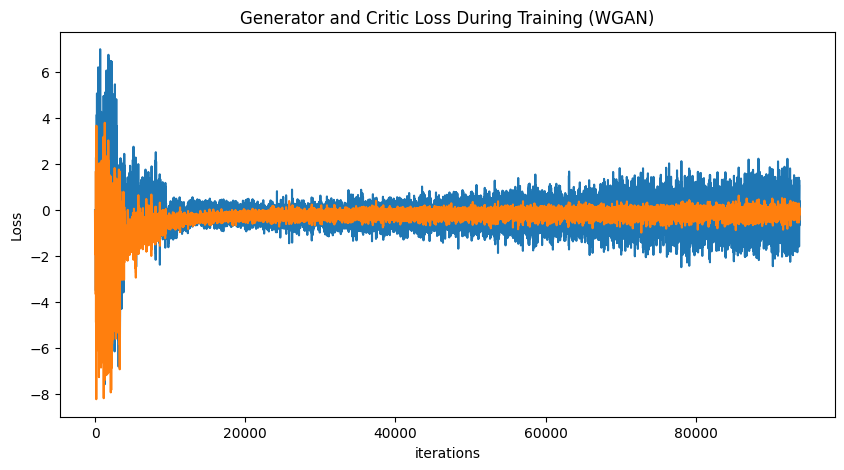

In [13]:
plot_loss(losses_generator_wgan, losses_critic_wgan, "Generator and Critic Loss During Training (WGAN)")

### Visualize the generated images

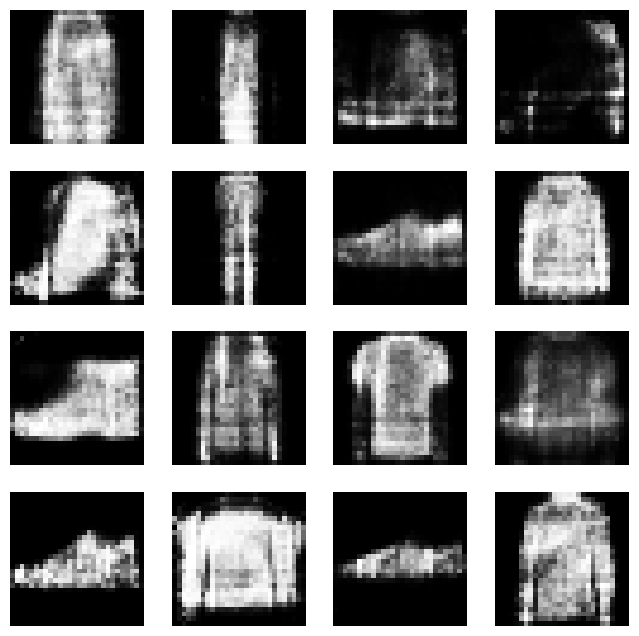

In [14]:
generate_images(generator=generator, label=7, config=config, device=device)

## Coditional GANs

### Define a Conditional Generator class

In [15]:
class ConditionalGenerator(nn.Module):
    def __init__(self):
        """
        Conditional Generator class for generating images based on given labels.

        Args:
            None

        Returns:
            None
        """
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(config.noise_dim + 10, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh())

    def forward(self, z, labels):
        """
        Forward pass of the Conditional Generator.

        Args:
            z (torch.Tensor): Input noise tensor of shape (batch_size, noise_dim).
            labels (torch.Tensor): Input label tensor of shape (batch_size).

        Returns:
            torch.Tensor: Generated image tensor of shape (batch_size, 28*28).
        """
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)


### Define a Conditional Critic class

In [16]:
class ConditionalCritic(nn.Module):
    """
    ConditionalCritic class represents a critic network for conditional GANs.

    Args:
        None

    Attributes:
        label_emb (nn.Embedding): Embedding layer for label embeddings.
        model (nn.Sequential): Sequential model for the critic network.

    Methods:
        forward(img, labels): Performs forward pass of the critic network.

    """

    def __init__(self):
        super(ConditionalCritic, self).__init__()
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1))

    def forward(self, img, labels):
        """
        Performs forward pass of the critic network.

        Args:
            img (torch.Tensor): Input image tensor.
            labels (torch.Tensor): Input label tensor.

        Returns:
            torch.Tensor: Output tensor from the critic network.

        """
        # Embed labels and concatenate them with the image
        c = self.label_emb(labels)
        x = torch.cat([img.view(img.size(0), -1), c], 1)
        return self.model(x)


### Initialize conditional GAN

In [17]:
conditional_generator = ConditionalGenerator().to(device)
conditional_critic = ConditionalCritic().to(device)

### Initializing Optimizers for Conditional Models

In [18]:
optim_conditional_critic = optim.RMSprop(conditional_critic.parameters(), lr=config.lr)
optim_conditional_generator = optim.RMSprop(conditional_generator.parameters(), lr=config.lr)

### Conditional GAN Training

In [19]:
def update_progress_bars(pbar_inner, pbar_outer, epoch, i, train_loader_len, critic_loss, generator_loss):
    # Update the inner progress bar after each batch
    pbar_inner.update(1)
    
    # Optional: print losses without breaking the progress bar layout
    if i == train_loader_len - 1:
        pbar_inner.write(f"Batch {i + 1}/{train_loader_len} - Loss D: {critic_loss.item():.4f}, loss G: {generator_loss.item():.4f}")


In [20]:
losses_critic_conditional = []
losses_generator_conditional = []
train_loader_len = len(train_loader)

# Training loop with progress bars
with tqdm(total=config.num_epochs, desc="Conditional GAN Overall Training Progress", unit='epoch') as pbar_outer:
    for epoch in range(config.num_epochs):
        with tqdm(total=train_loader_len, desc=f"Epoch {epoch + 1}/{config.num_epochs}", unit='batch') as pbar_inner:
            for i, (images, labels) in enumerate(train_loader):
                # Preparing the data
                real_images = images.to(device).view(images.size(0), -1)
                labels = labels.to(device)
                batch_size = real_images.size(0)
                real_labels = torch.full((batch_size, 1), 1, device=device)
                fake_labels = torch.full((batch_size, 1), 0, device=device)

                # Training conditional critic
                for _ in range(config.critic_iter):
                    conditional_critic.zero_grad()

                    # Real images
                    real_pred = conditional_critic(real_images, labels)
                    real_loss = -torch.mean(real_pred)

                    # Fake images
                    z = torch.randn(batch_size, config.noise_dim, device=device)
                    fake_images = conditional_generator(z, labels)
                    fake_pred = conditional_critic(fake_images.detach(), labels)
                    fake_loss = torch.mean(fake_pred)

                    # Total loss and optimization step
                    critic_loss = real_loss + fake_loss
                    critic_loss.backward()
                    optim_conditional_critic.step()

                    # Weight clipping
                    weight_clipping(conditional_critic, config.clip_value)

                # Training conditional generator
                conditional_generator.zero_grad()

                # Generating noise and labels
                gen_pred = conditional_critic(fake_images, labels)
                generator_loss = -torch.mean(gen_pred)

                generator_loss.backward()
                optim_conditional_generator.step()

                # Saving loss values
                losses_critic_conditional.append(critic_loss.item())
                losses_generator_conditional.append(generator_loss.item())

                # Update the inner progress bar after each batch
                pbar_inner.update(1)
                
                # Optional: print losses without breaking the progress bar layout
                if i == train_loader_len - 1:
                    pbar_inner.write(f"Batch {i + 1}/{train_loader_len} - Loss D: {critic_loss.item():.4f}, loss G: {generator_loss.item():.4f}")
                
        # Update the outer progress bar after each epoch
        pbar_outer.update(1)



Conditional GAN Overall Training Progress:   0%|          | 0/100 [00:00<?, ?epoch/s]


Conditional GAN Overall Training Progress:   1%|          | 1/100 [00:18<30:04, 18.23s/epoch]

Batch 938/938 - Loss D: -2.7978, loss G: 1.9437



Conditional GAN Overall Training Progress:   2%|▏         | 2/100 [00:36<29:42, 18.19s/epoch]

Batch 938/938 - Loss D: -0.0900, loss G: 2.5595



Conditional GAN Overall Training Progress:   3%|▎         | 3/100 [00:54<29:11, 18.06s/epoch]

Batch 938/938 - Loss D: -0.9817, loss G: -2.3931



Conditional GAN Overall Training Progress:   4%|▍         | 4/100 [01:12<28:50, 18.03s/epoch]

Batch 938/938 - Loss D: -2.0467, loss G: 1.2167



Conditional GAN Overall Training Progress:   5%|▌         | 5/100 [01:30<28:44, 18.15s/epoch]

Batch 938/938 - Loss D: -1.4328, loss G: -0.9898



Conditional GAN Overall Training Progress:   6%|▌         | 6/100 [01:48<28:32, 18.22s/epoch]

Batch 938/938 - Loss D: -1.3353, loss G: -0.9199



Conditional GAN Overall Training Progress:   7%|▋         | 7/100 [02:07<28:14, 18.22s/epoch]

Batch 938/938 - Loss D: -0.8768, loss G: -1.1372



Conditional GAN Overall Training Progress:   8%|▊         | 8/100 [02:25<28:01, 18.28s/epoch]

Batch 938/938 - Loss D: -0.8058, loss G: -1.1979



Conditional GAN Overall Training Progress:   9%|▉         | 9/100 [02:43<27:36, 18.20s/epoch]

Batch 938/938 - Loss D: -0.7276, loss G: -1.1779



Conditional GAN Overall Training Progress:  10%|█         | 10/100 [03:01<27:08, 18.09s/epoch]

Batch 938/938 - Loss D: -0.5516, loss G: -0.8411



Conditional GAN Overall Training Progress:  11%|█         | 11/100 [03:19<26:41, 17.99s/epoch]

Batch 938/938 - Loss D: -0.6323, loss G: -1.0517



Conditional GAN Overall Training Progress:  12%|█▏        | 12/100 [03:37<26:25, 18.02s/epoch]

Batch 938/938 - Loss D: -0.5148, loss G: -0.9668



Conditional GAN Overall Training Progress:  13%|█▎        | 13/100 [03:55<26:12, 18.08s/epoch]

Batch 938/938 - Loss D: -0.5368, loss G: -0.7211



Conditional GAN Overall Training Progress:  14%|█▍        | 14/100 [04:13<25:49, 18.02s/epoch]

Batch 938/938 - Loss D: -0.5651, loss G: -1.1754



Conditional GAN Overall Training Progress:  15%|█▌        | 15/100 [04:31<25:31, 18.01s/epoch]

Batch 938/938 - Loss D: -0.5180, loss G: -1.3279



Conditional GAN Overall Training Progress:  16%|█▌        | 16/100 [04:49<25:16, 18.06s/epoch]

Batch 938/938 - Loss D: -0.4649, loss G: -0.9331



Conditional GAN Overall Training Progress:  17%|█▋        | 17/100 [05:07<24:52, 17.98s/epoch]

Batch 938/938 - Loss D: -0.6846, loss G: -1.0796



Conditional GAN Overall Training Progress:  18%|█▊        | 18/100 [05:25<24:30, 17.94s/epoch]

Batch 938/938 - Loss D: -0.4040, loss G: -0.6851



Conditional GAN Overall Training Progress:  19%|█▉        | 19/100 [05:43<24:12, 17.94s/epoch]

Batch 938/938 - Loss D: -0.4682, loss G: -1.1444



Conditional GAN Overall Training Progress:  20%|██        | 20/100 [06:01<23:55, 17.94s/epoch]

Batch 938/938 - Loss D: -0.3911, loss G: -0.9601



Conditional GAN Overall Training Progress:  21%|██        | 21/100 [06:19<23:41, 17.99s/epoch]

Batch 938/938 - Loss D: -0.4670, loss G: -0.9887



Conditional GAN Overall Training Progress:  22%|██▏       | 22/100 [06:37<23:26, 18.03s/epoch]

Batch 938/938 - Loss D: -0.2630, loss G: -0.6468



Conditional GAN Overall Training Progress:  23%|██▎       | 23/100 [06:55<23:07, 18.02s/epoch]

Batch 938/938 - Loss D: -0.2598, loss G: -0.7291



Conditional GAN Overall Training Progress:  24%|██▍       | 24/100 [07:13<22:49, 18.02s/epoch]

Batch 938/938 - Loss D: -0.1958, loss G: -0.8827



Conditional GAN Overall Training Progress:  25%|██▌       | 25/100 [07:31<22:28, 17.97s/epoch]

Batch 938/938 - Loss D: -0.3111, loss G: -1.1244



Conditional GAN Overall Training Progress:  26%|██▌       | 26/100 [07:49<22:05, 17.91s/epoch]

Batch 938/938 - Loss D: -0.2828, loss G: -0.9355



Conditional GAN Overall Training Progress:  27%|██▋       | 27/100 [08:07<21:49, 17.94s/epoch]

Batch 938/938 - Loss D: -0.2759, loss G: -0.7658



Conditional GAN Overall Training Progress:  28%|██▊       | 28/100 [08:24<21:31, 17.93s/epoch]

Batch 938/938 - Loss D: -0.1900, loss G: -0.8395



Conditional GAN Overall Training Progress:  29%|██▉       | 29/100 [08:43<21:17, 17.99s/epoch]

Batch 938/938 - Loss D: -0.2942, loss G: -0.5780



Conditional GAN Overall Training Progress:  30%|███       | 30/100 [09:00<20:53, 17.91s/epoch]

Batch 938/938 - Loss D: -0.3067, loss G: -0.9355



Conditional GAN Overall Training Progress:  31%|███       | 31/100 [09:18<20:33, 17.88s/epoch]

Batch 938/938 - Loss D: -0.4997, loss G: -0.8257



Conditional GAN Overall Training Progress:  32%|███▏      | 32/100 [09:37<20:27, 18.05s/epoch]

Batch 938/938 - Loss D: -0.2463, loss G: -1.0330



Conditional GAN Overall Training Progress:  33%|███▎      | 33/100 [09:55<20:10, 18.07s/epoch]

Batch 938/938 - Loss D: -0.3522, loss G: -1.1994



Conditional GAN Overall Training Progress:  34%|███▍      | 34/100 [10:13<19:53, 18.08s/epoch]

Batch 938/938 - Loss D: -0.3217, loss G: -0.9645



Conditional GAN Overall Training Progress:  35%|███▌      | 35/100 [10:31<19:38, 18.13s/epoch]

Batch 938/938 - Loss D: -0.3710, loss G: -0.1667



Conditional GAN Overall Training Progress:  36%|███▌      | 36/100 [10:49<19:19, 18.12s/epoch]

Batch 938/938 - Loss D: -0.5693, loss G: -0.5205



Conditional GAN Overall Training Progress:  37%|███▋      | 37/100 [11:07<18:55, 18.02s/epoch]

Batch 938/938 - Loss D: -0.2757, loss G: -0.5779



Conditional GAN Overall Training Progress:  38%|███▊      | 38/100 [11:25<18:34, 17.97s/epoch]

Batch 938/938 - Loss D: -0.3340, loss G: -1.0573



Conditional GAN Overall Training Progress:  39%|███▉      | 39/100 [11:43<18:17, 18.00s/epoch]

Batch 938/938 - Loss D: -0.4846, loss G: -0.8378



Conditional GAN Overall Training Progress:  40%|████      | 40/100 [12:01<17:56, 17.95s/epoch]

Batch 938/938 - Loss D: -0.1603, loss G: -0.4546



Conditional GAN Overall Training Progress:  41%|████      | 41/100 [12:19<17:39, 17.95s/epoch]

Batch 938/938 - Loss D: -0.2011, loss G: -0.4671



Conditional GAN Overall Training Progress:  42%|████▏     | 42/100 [12:37<17:21, 17.96s/epoch]

Batch 938/938 - Loss D: -0.3407, loss G: -0.7706



Conditional GAN Overall Training Progress:  43%|████▎     | 43/100 [12:54<16:59, 17.89s/epoch]

Batch 938/938 - Loss D: -0.3416, loss G: -0.6908



Conditional GAN Overall Training Progress:  44%|████▍     | 44/100 [13:13<16:47, 17.99s/epoch]

Batch 938/938 - Loss D: -0.3358, loss G: -0.2355



Conditional GAN Overall Training Progress:  45%|████▌     | 45/100 [13:31<16:33, 18.06s/epoch]

Batch 938/938 - Loss D: -0.3166, loss G: -0.4091



Conditional GAN Overall Training Progress:  46%|████▌     | 46/100 [13:49<16:13, 18.03s/epoch]

Batch 938/938 - Loss D: -0.2357, loss G: -0.4451



Conditional GAN Overall Training Progress:  47%|████▋     | 47/100 [14:07<15:53, 17.99s/epoch]

Batch 938/938 - Loss D: -0.1781, loss G: -0.2208



Conditional GAN Overall Training Progress:  48%|████▊     | 48/100 [14:25<15:34, 17.97s/epoch]

Batch 938/938 - Loss D: -0.2207, loss G: -0.0217



Conditional GAN Overall Training Progress:  49%|████▉     | 49/100 [14:43<15:17, 17.99s/epoch]

Batch 938/938 - Loss D: -0.3126, loss G: -0.5128



Conditional GAN Overall Training Progress:  50%|█████     | 50/100 [15:01<15:01, 18.03s/epoch]

Batch 938/938 - Loss D: -0.2899, loss G: -0.2463



Conditional GAN Overall Training Progress:  51%|█████     | 51/100 [15:19<14:42, 18.02s/epoch]

Batch 938/938 - Loss D: -0.4366, loss G: 0.0842



Conditional GAN Overall Training Progress:  52%|█████▏    | 52/100 [15:36<14:21, 17.94s/epoch]

Batch 938/938 - Loss D: -0.1563, loss G: -0.3827



Conditional GAN Overall Training Progress:  53%|█████▎    | 53/100 [15:54<14:02, 17.93s/epoch]

Batch 938/938 - Loss D: -0.1901, loss G: -0.1335



Conditional GAN Overall Training Progress:  54%|█████▍    | 54/100 [16:12<13:43, 17.90s/epoch]

Batch 938/938 - Loss D: -0.1689, loss G: -0.4736



Conditional GAN Overall Training Progress:  55%|█████▌    | 55/100 [16:30<13:26, 17.92s/epoch]

Batch 938/938 - Loss D: -0.2296, loss G: 0.2422



Conditional GAN Overall Training Progress:  56%|█████▌    | 56/100 [16:48<13:07, 17.90s/epoch]

Batch 938/938 - Loss D: -0.2290, loss G: -0.1873



Conditional GAN Overall Training Progress:  57%|█████▋    | 57/100 [17:06<12:51, 17.95s/epoch]

Batch 938/938 - Loss D: -0.2723, loss G: 0.0526



Conditional GAN Overall Training Progress:  58%|█████▊    | 58/100 [17:24<12:36, 18.00s/epoch]

Batch 938/938 - Loss D: -0.3204, loss G: -0.7721



Conditional GAN Overall Training Progress:  59%|█████▉    | 59/100 [17:42<12:18, 18.01s/epoch]

Batch 938/938 - Loss D: -0.2574, loss G: 0.0257



Conditional GAN Overall Training Progress:  60%|██████    | 60/100 [18:00<11:56, 17.92s/epoch]

Batch 938/938 - Loss D: -0.3068, loss G: 0.4603



Conditional GAN Overall Training Progress:  61%|██████    | 61/100 [18:18<11:42, 18.02s/epoch]

Batch 938/938 - Loss D: -0.4562, loss G: 0.6907



Conditional GAN Overall Training Progress:  62%|██████▏   | 62/100 [18:36<11:23, 18.00s/epoch]

Batch 938/938 - Loss D: -0.2852, loss G: 0.4318



Conditional GAN Overall Training Progress:  63%|██████▎   | 63/100 [18:54<11:08, 18.07s/epoch]

Batch 938/938 - Loss D: -0.1640, loss G: -0.0007



Conditional GAN Overall Training Progress:  64%|██████▍   | 64/100 [19:13<10:51, 18.09s/epoch]

Batch 938/938 - Loss D: -0.2013, loss G: 0.2798



Conditional GAN Overall Training Progress:  65%|██████▌   | 65/100 [19:31<10:32, 18.07s/epoch]

Batch 938/938 - Loss D: -0.2025, loss G: -0.1584



Conditional GAN Overall Training Progress:  66%|██████▌   | 66/100 [19:48<10:13, 18.03s/epoch]

Batch 938/938 - Loss D: -0.1149, loss G: -0.0545



Conditional GAN Overall Training Progress:  67%|██████▋   | 67/100 [20:06<09:51, 17.93s/epoch]

Batch 938/938 - Loss D: -0.2181, loss G: -0.1748



Conditional GAN Overall Training Progress:  68%|██████▊   | 68/100 [20:24<09:35, 17.99s/epoch]

Batch 938/938 - Loss D: -0.2307, loss G: 0.3683



Conditional GAN Overall Training Progress:  69%|██████▉   | 69/100 [20:42<09:19, 18.05s/epoch]

Batch 938/938 - Loss D: -0.2833, loss G: 0.3411



Conditional GAN Overall Training Progress:  70%|███████   | 70/100 [21:00<08:57, 17.93s/epoch]

Batch 938/938 - Loss D: -0.3184, loss G: 0.0791



Conditional GAN Overall Training Progress:  71%|███████   | 71/100 [21:18<08:40, 17.94s/epoch]

Batch 938/938 - Loss D: -0.1097, loss G: -0.1248



Conditional GAN Overall Training Progress:  72%|███████▏  | 72/100 [21:36<08:22, 17.95s/epoch]

Batch 938/938 - Loss D: -0.1531, loss G: -0.0313



Conditional GAN Overall Training Progress:  73%|███████▎  | 73/100 [21:54<08:05, 17.97s/epoch]

Batch 938/938 - Loss D: -0.0599, loss G: -0.1899



Conditional GAN Overall Training Progress:  74%|███████▍  | 74/100 [22:12<07:47, 17.97s/epoch]

Batch 938/938 - Loss D: -0.2380, loss G: -0.0892



Conditional GAN Overall Training Progress:  75%|███████▌  | 75/100 [22:30<07:26, 17.85s/epoch]

Batch 938/938 - Loss D: -0.1839, loss G: -0.3324



Conditional GAN Overall Training Progress:  76%|███████▌  | 76/100 [22:48<07:09, 17.92s/epoch]

Batch 938/938 - Loss D: -0.2811, loss G: 0.4835



Conditional GAN Overall Training Progress:  77%|███████▋  | 77/100 [23:06<06:52, 17.93s/epoch]

Batch 938/938 - Loss D: -0.1482, loss G: 0.1460



Conditional GAN Overall Training Progress:  78%|███████▊  | 78/100 [23:24<06:34, 17.92s/epoch]

Batch 938/938 - Loss D: -0.4092, loss G: 0.2777



Conditional GAN Overall Training Progress:  79%|███████▉  | 79/100 [23:41<06:14, 17.85s/epoch]

Batch 938/938 - Loss D: -0.1765, loss G: -0.4405



Conditional GAN Overall Training Progress:  80%|████████  | 80/100 [23:59<05:56, 17.80s/epoch]

Batch 938/938 - Loss D: -0.1886, loss G: -0.3396



Conditional GAN Overall Training Progress:  81%|████████  | 81/100 [24:17<05:39, 17.88s/epoch]

Batch 938/938 - Loss D: -0.2285, loss G: -0.1614



Conditional GAN Overall Training Progress:  82%|████████▏ | 82/100 [24:34<05:18, 17.72s/epoch]

Batch 938/938 - Loss D: -0.1767, loss G: -0.2718



Conditional GAN Overall Training Progress:  83%|████████▎ | 83/100 [24:52<05:01, 17.76s/epoch]

Batch 938/938 - Loss D: -0.0833, loss G: 0.2159



Conditional GAN Overall Training Progress:  84%|████████▍ | 84/100 [25:10<04:45, 17.83s/epoch]

Batch 938/938 - Loss D: -0.4073, loss G: -0.0415



Conditional GAN Overall Training Progress:  85%|████████▌ | 85/100 [25:28<04:28, 17.92s/epoch]

Batch 938/938 - Loss D: -0.1814, loss G: 0.3839



Conditional GAN Overall Training Progress:  86%|████████▌ | 86/100 [25:46<04:11, 17.94s/epoch]

Batch 938/938 - Loss D: -0.2771, loss G: -0.5864



Conditional GAN Overall Training Progress:  87%|████████▋ | 87/100 [26:04<03:53, 17.97s/epoch]

Batch 938/938 - Loss D: -0.1259, loss G: -0.4201



Conditional GAN Overall Training Progress:  88%|████████▊ | 88/100 [26:22<03:35, 17.98s/epoch]

Batch 938/938 - Loss D: -0.2046, loss G: 0.2976



Conditional GAN Overall Training Progress:  89%|████████▉ | 89/100 [26:40<03:18, 18.02s/epoch]

Batch 938/938 - Loss D: -0.4151, loss G: 0.5823



Conditional GAN Overall Training Progress:  90%|█████████ | 90/100 [26:59<03:00, 18.05s/epoch]

Batch 938/938 - Loss D: -0.2673, loss G: 0.0358



Conditional GAN Overall Training Progress:  91%|█████████ | 91/100 [27:17<02:42, 18.01s/epoch]

Batch 938/938 - Loss D: -0.1875, loss G: 0.0444



Conditional GAN Overall Training Progress:  92%|█████████▏| 92/100 [27:35<02:24, 18.03s/epoch]

Batch 938/938 - Loss D: -0.1688, loss G: -0.2178



Conditional GAN Overall Training Progress:  93%|█████████▎| 93/100 [27:53<02:06, 18.02s/epoch]

Batch 938/938 - Loss D: -0.1254, loss G: -0.1028



Conditional GAN Overall Training Progress:  94%|█████████▍| 94/100 [28:10<01:47, 17.94s/epoch]

Batch 938/938 - Loss D: -0.1353, loss G: -0.4548



Conditional GAN Overall Training Progress:  95%|█████████▌| 95/100 [28:29<01:30, 18.02s/epoch]

Batch 938/938 - Loss D: -0.1688, loss G: -0.3735



Conditional GAN Overall Training Progress:  96%|█████████▌| 96/100 [28:47<01:12, 18.06s/epoch]

Batch 938/938 - Loss D: -0.1162, loss G: 0.4244



Conditional GAN Overall Training Progress:  97%|█████████▋| 97/100 [29:05<00:54, 18.10s/epoch]

Batch 938/938 - Loss D: -0.1042, loss G: -0.0332



Conditional GAN Overall Training Progress:  98%|█████████▊| 98/100 [29:23<00:36, 18.10s/epoch]

Batch 938/938 - Loss D: -0.1038, loss G: -0.0188



Conditional GAN Overall Training Progress:  99%|█████████▉| 99/100 [29:41<00:18, 18.07s/epoch]

Batch 938/938 - Loss D: -0.1080, loss G: -0.6668



Conditional GAN Overall Training Progress: 100%|██████████| 100/100 [29:59<00:00, 17.99s/epoch]

Batch 938/938 - Loss D: -0.2033, loss G: -0.4801


### Visualize the loss

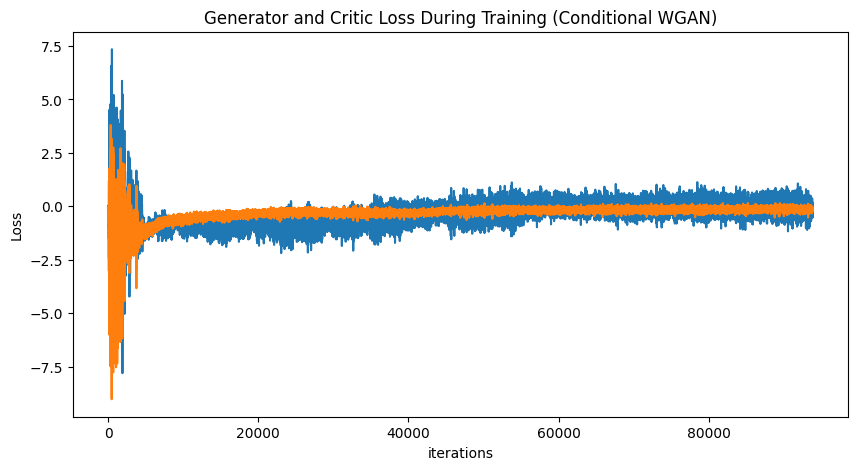

In [21]:
plot_loss(losses_generator_conditional, losses_critic_conditional, "Generator and Critic Loss During Training (Conditional WGAN)")


### Generate images

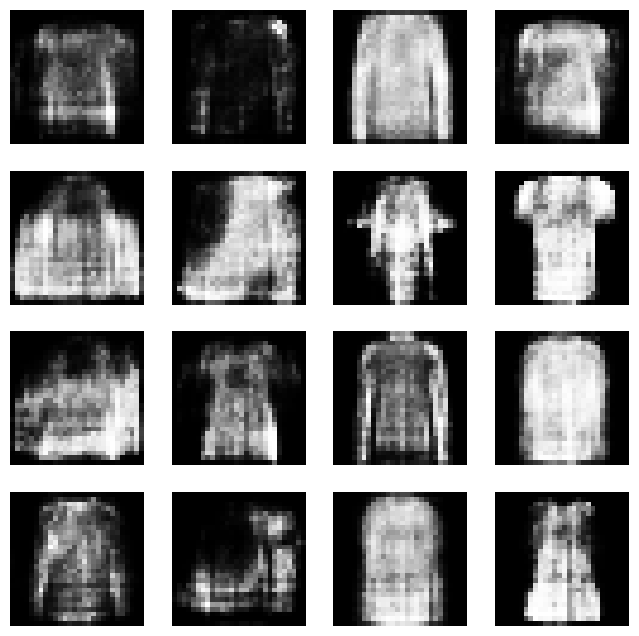

In [22]:
generate_images(conditional_generator, label=2, config=config, device=device)


## WGAN-GP

### Define a Gradient penalty method

In [23]:
def compute_gradient_penalty(critic, real_samples, fake_samples, labels):
    """
    Computes the gradient penalty for the critic in a GAN model.

    Parameters:
    - critic (torch.nn.Module): The critic model.
    - real_samples (torch.Tensor): Real samples from the dataset.
    - fake_samples (torch.Tensor): Fake samples generated by the generator.
    - labels (torch.Tensor): Labels for the samples.

    Returns:
    - gradient_penalty (torch.Tensor): The computed gradient penalty.
    """
    alpha = torch.rand((real_samples.size(0), 1), device=device).expand_as(real_samples)
    interpolated_samples = alpha * real_samples + (1 - alpha) * fake_samples
    interpolated_samples.requires_grad_(True)

    # Critic evaluation on interpolated samples
    interpolated_pred = critic(interpolated_samples, labels)

    # Gradient calculation
    gradients = torch.autograd.grad(
        outputs=interpolated_pred, inputs=interpolated_samples,
        grad_outputs=torch.ones(interpolated_pred.size(), device=device),
        create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Gradient norm and penalty
    gradients_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty


### WGAN-GP training

#### Redefine the Conditional Generator and Conditional Critic

In [24]:
conditional_generator = ConditionalGenerator().to(device)
conditional_critic = ConditionalCritic().to(device)

optim_conditional_critic = optim.RMSprop(conditional_critic.parameters(), lr=config.lr)
optim_conditional_generator = optim.RMSprop(conditional_generator.parameters(), lr=config.lr)


#### Train the WGAN-GP

In [25]:
lambda_gp = 10
losses_critic_wgangp = []
losses_generator_wgangp = []
train_loader_len = len(train_loader)

# Training loop with progress bars
with tqdm(total=config.num_epochs, desc="WGAN-GP Overall Training Progress", unit='epoch') as pbar_outer:
    for epoch in range(config.num_epochs):
        with tqdm(total=train_loader_len, desc=f"Epoch {epoch + 1}/{config.num_epochs}", unit='batch') as pbar_inner:
            for i, (images, labels) in enumerate(train_loader):
                real_images = images.to(device).view(images.size(0), -1)
                labels = labels.to(device)
                batch_size = real_images.size(0)

                # Training conditional critic
                conditional_critic.zero_grad()

                # Real images
                real_pred = conditional_critic(real_images, labels)
                real_loss = -torch.mean(real_pred)

                # Fake images
                z = torch.randn(batch_size, config.noise_dim, device=device)
                fake_images = conditional_generator(z, labels)
                fake_pred = conditional_critic(fake_images.detach(), labels)
                fake_loss = torch.mean(fake_pred)

                # Calculating gradient penalty
                gradient_penalty = compute_gradient_penalty(conditional_critic, real_images, fake_images.detach(), labels)
                critic_loss = real_loss + fake_loss + lambda_gp * gradient_penalty

                critic_loss.backward()
                optim_conditional_critic.step()

                # Training conditional generator
                conditional_generator.zero_grad()

                # Regenerating fake images
                fake_images = conditional_generator(z, labels)
                gen_pred = conditional_critic(fake_images, labels)
                generator_loss = -torch.mean(gen_pred)

                generator_loss.backward()
                optim_conditional_generator.step()

                # Saving loss values
                losses_critic_wgangp.append(critic_loss.item())
                losses_generator_wgangp.append(generator_loss.item())

                # Update the inner progress bar after each batch
                pbar_inner.update(1)
                
                # Optional: print losses without breaking the progress bar layout
                if i == train_loader_len - 1:
                    pbar_inner.write(f"Batch {i + 1}/{train_loader_len} - Loss D: {critic_loss.item():.4f}, loss G: {generator_loss.item():.4f}")

        # Update the outer progress bar after each epoch
        pbar_outer.update(1)



WGAN-GP Overall Training Progress:   1%|          | 1/100 [00:10<18:02, 10.94s/epoch]

Batch 938/938 - Loss D: -8.3127, loss G: 7.2876



WGAN-GP Overall Training Progress:   2%|▏         | 2/100 [00:21<17:44, 10.86s/epoch]

Batch 938/938 - Loss D: -4.6496, loss G: -2.2923



WGAN-GP Overall Training Progress:   3%|▎         | 3/100 [00:32<17:32, 10.85s/epoch]

Batch 938/938 - Loss D: -5.7846, loss G: 2.6138



WGAN-GP Overall Training Progress:   4%|▍         | 4/100 [00:43<17:12, 10.76s/epoch]

Batch 938/938 - Loss D: -7.1762, loss G: -2.8232



WGAN-GP Overall Training Progress:   5%|▌         | 5/100 [00:54<17:10, 10.84s/epoch]

Batch 938/938 - Loss D: -4.6305, loss G: -8.0655



WGAN-GP Overall Training Progress:   6%|▌         | 6/100 [01:04<16:55, 10.81s/epoch]

Batch 938/938 - Loss D: -0.4299, loss G: -8.1476



WGAN-GP Overall Training Progress:   7%|▋         | 7/100 [01:15<16:46, 10.82s/epoch]

Batch 938/938 - Loss D: -3.0477, loss G: -2.4353



WGAN-GP Overall Training Progress:   8%|▊         | 8/100 [01:26<16:35, 10.82s/epoch]

Batch 938/938 - Loss D: -3.5255, loss G: -2.7800



WGAN-GP Overall Training Progress:   9%|▉         | 9/100 [01:37<16:20, 10.77s/epoch]

Batch 938/938 - Loss D: -3.9780, loss G: -1.9498



WGAN-GP Overall Training Progress:  10%|█         | 10/100 [01:47<16:08, 10.76s/epoch]

Batch 938/938 - Loss D: -2.4849, loss G: -1.7955



WGAN-GP Overall Training Progress:  11%|█         | 11/100 [01:58<15:58, 10.77s/epoch]

Batch 938/938 - Loss D: -2.3569, loss G: -1.2123



WGAN-GP Overall Training Progress:  12%|█▏        | 12/100 [02:09<15:43, 10.72s/epoch]

Batch 938/938 - Loss D: -1.8792, loss G: 0.4491



WGAN-GP Overall Training Progress:  13%|█▎        | 13/100 [02:20<15:34, 10.75s/epoch]

Batch 938/938 - Loss D: -3.1902, loss G: 3.0987



WGAN-GP Overall Training Progress:  14%|█▍        | 14/100 [02:31<15:26, 10.78s/epoch]

Batch 938/938 - Loss D: -2.7585, loss G: 0.1004



WGAN-GP Overall Training Progress:  15%|█▌        | 15/100 [02:41<15:19, 10.82s/epoch]

Batch 938/938 - Loss D: -2.5011, loss G: -2.1504



WGAN-GP Overall Training Progress:  16%|█▌        | 16/100 [02:52<15:06, 10.80s/epoch]

Batch 938/938 - Loss D: -2.2849, loss G: 1.1775



WGAN-GP Overall Training Progress:  17%|█▋        | 17/100 [03:03<14:57, 10.81s/epoch]

Batch 938/938 - Loss D: -2.7243, loss G: 0.6127



WGAN-GP Overall Training Progress:  18%|█▊        | 18/100 [03:14<14:42, 10.76s/epoch]

Batch 938/938 - Loss D: -3.6817, loss G: 0.9013



WGAN-GP Overall Training Progress:  19%|█▉        | 19/100 [03:25<14:33, 10.78s/epoch]

Batch 938/938 - Loss D: -2.7340, loss G: -1.1995



WGAN-GP Overall Training Progress:  20%|██        | 20/100 [03:35<14:23, 10.80s/epoch]

Batch 938/938 - Loss D: -1.3417, loss G: 1.0538



WGAN-GP Overall Training Progress:  21%|██        | 21/100 [03:46<14:15, 10.83s/epoch]

Batch 938/938 - Loss D: -2.4241, loss G: 0.5072



WGAN-GP Overall Training Progress:  22%|██▏       | 22/100 [03:57<14:07, 10.87s/epoch]

Batch 938/938 - Loss D: -1.8266, loss G: 1.2185



WGAN-GP Overall Training Progress:  23%|██▎       | 23/100 [04:08<13:49, 10.77s/epoch]

Batch 938/938 - Loss D: -2.1581, loss G: 3.2836



WGAN-GP Overall Training Progress:  24%|██▍       | 24/100 [04:19<13:37, 10.76s/epoch]

Batch 938/938 - Loss D: -1.7682, loss G: 0.7529



WGAN-GP Overall Training Progress:  25%|██▌       | 25/100 [04:29<13:26, 10.75s/epoch]

Batch 938/938 - Loss D: -1.5586, loss G: 0.1966



WGAN-GP Overall Training Progress:  26%|██▌       | 26/100 [04:40<13:18, 10.79s/epoch]

Batch 938/938 - Loss D: -1.3898, loss G: -0.3842



WGAN-GP Overall Training Progress:  27%|██▋       | 27/100 [04:51<13:09, 10.82s/epoch]

Batch 938/938 - Loss D: -1.0315, loss G: 0.8095



WGAN-GP Overall Training Progress:  28%|██▊       | 28/100 [05:02<13:03, 10.88s/epoch]

Batch 938/938 - Loss D: -2.0907, loss G: 2.9434



WGAN-GP Overall Training Progress:  29%|██▉       | 29/100 [05:13<12:51, 10.87s/epoch]

Batch 938/938 - Loss D: -1.5079, loss G: 1.7754



WGAN-GP Overall Training Progress:  30%|███       | 30/100 [05:24<12:40, 10.87s/epoch]

Batch 938/938 - Loss D: -2.0218, loss G: 2.3653



WGAN-GP Overall Training Progress:  31%|███       | 31/100 [05:35<12:29, 10.86s/epoch]

Batch 938/938 - Loss D: -1.0287, loss G: 0.6097



WGAN-GP Overall Training Progress:  32%|███▏      | 32/100 [05:45<12:09, 10.72s/epoch]

Batch 938/938 - Loss D: -1.1887, loss G: 1.4460



WGAN-GP Overall Training Progress:  33%|███▎      | 33/100 [05:56<11:57, 10.72s/epoch]

Batch 938/938 - Loss D: -1.4136, loss G: 1.9709



WGAN-GP Overall Training Progress:  34%|███▍      | 34/100 [06:07<11:53, 10.82s/epoch]

Batch 938/938 - Loss D: -1.0276, loss G: -0.0150



WGAN-GP Overall Training Progress:  35%|███▌      | 35/100 [06:18<11:44, 10.84s/epoch]

Batch 938/938 - Loss D: -1.0199, loss G: 0.4065



WGAN-GP Overall Training Progress:  36%|███▌      | 36/100 [06:29<11:41, 10.96s/epoch]

Batch 938/938 - Loss D: -0.5953, loss G: -1.9229



WGAN-GP Overall Training Progress:  37%|███▋      | 37/100 [06:40<11:32, 10.99s/epoch]

Batch 938/938 - Loss D: -0.9772, loss G: -1.2867



WGAN-GP Overall Training Progress:  38%|███▊      | 38/100 [06:51<11:20, 10.98s/epoch]

Batch 938/938 - Loss D: -0.8631, loss G: -0.6976



WGAN-GP Overall Training Progress:  39%|███▉      | 39/100 [07:02<11:10, 10.99s/epoch]

Batch 938/938 - Loss D: -0.8204, loss G: -1.2318



WGAN-GP Overall Training Progress:  40%|████      | 40/100 [07:13<10:56, 10.94s/epoch]

Batch 938/938 - Loss D: -1.8157, loss G: 0.6947



WGAN-GP Overall Training Progress:  41%|████      | 41/100 [07:24<10:44, 10.92s/epoch]

Batch 938/938 - Loss D: -1.1695, loss G: -0.9718



WGAN-GP Overall Training Progress:  42%|████▏     | 42/100 [07:34<10:28, 10.83s/epoch]

Batch 938/938 - Loss D: -1.1240, loss G: -2.4255



WGAN-GP Overall Training Progress:  43%|████▎     | 43/100 [07:45<10:15, 10.80s/epoch]

Batch 938/938 - Loss D: -0.7739, loss G: -1.1643



WGAN-GP Overall Training Progress:  44%|████▍     | 44/100 [07:56<10:04, 10.79s/epoch]

Batch 938/938 - Loss D: -0.7971, loss G: -1.2022



WGAN-GP Overall Training Progress:  45%|████▌     | 45/100 [08:06<09:51, 10.75s/epoch]

Batch 938/938 - Loss D: -0.9382, loss G: -2.0768



WGAN-GP Overall Training Progress:  46%|████▌     | 46/100 [08:17<09:39, 10.73s/epoch]

Batch 938/938 - Loss D: -0.7141, loss G: -3.3536



WGAN-GP Overall Training Progress:  47%|████▋     | 47/100 [08:28<09:30, 10.76s/epoch]

Batch 938/938 - Loss D: -0.9264, loss G: -3.3010



WGAN-GP Overall Training Progress:  48%|████▊     | 48/100 [08:39<09:18, 10.74s/epoch]

Batch 938/938 - Loss D: -0.5907, loss G: -2.2901



WGAN-GP Overall Training Progress:  49%|████▉     | 49/100 [08:49<09:06, 10.72s/epoch]

Batch 938/938 - Loss D: -1.0005, loss G: -1.0519



WGAN-GP Overall Training Progress:  50%|█████     | 50/100 [09:00<08:54, 10.69s/epoch]

Batch 938/938 - Loss D: -1.0499, loss G: -1.2106



WGAN-GP Overall Training Progress:  51%|█████     | 51/100 [09:11<08:48, 10.78s/epoch]

Batch 938/938 - Loss D: -1.0694, loss G: -3.3611



WGAN-GP Overall Training Progress:  52%|█████▏    | 52/100 [09:22<08:37, 10.79s/epoch]

Batch 938/938 - Loss D: -0.6160, loss G: -2.2110



WGAN-GP Overall Training Progress:  53%|█████▎    | 53/100 [09:32<08:23, 10.72s/epoch]

Batch 938/938 - Loss D: -0.5854, loss G: -4.2203



WGAN-GP Overall Training Progress:  54%|█████▍    | 54/100 [09:43<08:14, 10.75s/epoch]

Batch 938/938 - Loss D: -0.7638, loss G: -2.1695



WGAN-GP Overall Training Progress:  55%|█████▌    | 55/100 [09:54<08:03, 10.74s/epoch]

Batch 938/938 - Loss D: -0.8546, loss G: -2.1973



WGAN-GP Overall Training Progress:  56%|█████▌    | 56/100 [10:04<07:50, 10.69s/epoch]

Batch 938/938 - Loss D: -0.9400, loss G: -3.5147



WGAN-GP Overall Training Progress:  57%|█████▋    | 57/100 [10:15<07:41, 10.73s/epoch]

Batch 938/938 - Loss D: -1.2847, loss G: -3.8462



WGAN-GP Overall Training Progress:  58%|█████▊    | 58/100 [10:26<07:32, 10.77s/epoch]

Batch 938/938 - Loss D: -0.7301, loss G: -2.6680



WGAN-GP Overall Training Progress:  59%|█████▉    | 59/100 [10:37<07:20, 10.74s/epoch]

Batch 938/938 - Loss D: -0.5118, loss G: -3.8708



WGAN-GP Overall Training Progress:  60%|██████    | 60/100 [10:47<07:10, 10.75s/epoch]

Batch 938/938 - Loss D: -1.0237, loss G: -3.7580



WGAN-GP Overall Training Progress:  61%|██████    | 61/100 [10:58<06:59, 10.75s/epoch]

Batch 938/938 - Loss D: -0.6338, loss G: -5.1397



WGAN-GP Overall Training Progress:  62%|██████▏   | 62/100 [11:09<06:47, 10.73s/epoch]

Batch 938/938 - Loss D: -0.9500, loss G: -4.5505



WGAN-GP Overall Training Progress:  63%|██████▎   | 63/100 [11:20<06:35, 10.70s/epoch]

Batch 938/938 - Loss D: -1.2738, loss G: -2.8681



WGAN-GP Overall Training Progress:  64%|██████▍   | 64/100 [11:30<06:25, 10.70s/epoch]

Batch 938/938 - Loss D: -0.5717, loss G: -2.7714



WGAN-GP Overall Training Progress:  65%|██████▌   | 65/100 [11:41<06:13, 10.68s/epoch]

Batch 938/938 - Loss D: -0.8941, loss G: -5.5730



WGAN-GP Overall Training Progress:  66%|██████▌   | 66/100 [11:51<06:02, 10.66s/epoch]

Batch 938/938 - Loss D: -0.4425, loss G: -3.2153



WGAN-GP Overall Training Progress:  67%|██████▋   | 67/100 [12:02<05:53, 10.72s/epoch]

Batch 938/938 - Loss D: -0.8353, loss G: -3.3050



WGAN-GP Overall Training Progress:  68%|██████▊   | 68/100 [12:13<05:42, 10.70s/epoch]

Batch 938/938 - Loss D: -1.4429, loss G: -3.7398



WGAN-GP Overall Training Progress:  69%|██████▉   | 69/100 [12:24<05:31, 10.69s/epoch]

Batch 938/938 - Loss D: -0.6710, loss G: -3.5740



WGAN-GP Overall Training Progress:  70%|███████   | 70/100 [12:34<05:20, 10.68s/epoch]

Batch 938/938 - Loss D: -0.8503, loss G: -4.6646



WGAN-GP Overall Training Progress:  71%|███████   | 71/100 [12:45<05:10, 10.70s/epoch]

Batch 938/938 - Loss D: -0.6670, loss G: -3.0729



WGAN-GP Overall Training Progress:  72%|███████▏  | 72/100 [12:56<04:59, 10.70s/epoch]

Batch 938/938 - Loss D: -0.8804, loss G: -4.4305



WGAN-GP Overall Training Progress:  73%|███████▎  | 73/100 [13:06<04:49, 10.71s/epoch]

Batch 938/938 - Loss D: -0.5079, loss G: -4.8603



WGAN-GP Overall Training Progress:  74%|███████▍  | 74/100 [13:17<04:37, 10.67s/epoch]

Batch 938/938 - Loss D: -0.7635, loss G: -2.8738



WGAN-GP Overall Training Progress:  75%|███████▌  | 75/100 [13:28<04:28, 10.76s/epoch]

Batch 938/938 - Loss D: -0.8203, loss G: -4.4352



WGAN-GP Overall Training Progress:  76%|███████▌  | 76/100 [13:39<04:18, 10.76s/epoch]

Batch 938/938 - Loss D: -1.2290, loss G: -4.1295



WGAN-GP Overall Training Progress:  77%|███████▋  | 77/100 [13:50<04:07, 10.76s/epoch]

Batch 938/938 - Loss D: -1.0258, loss G: -4.4550



WGAN-GP Overall Training Progress:  78%|███████▊  | 78/100 [14:00<03:57, 10.81s/epoch]

Batch 938/938 - Loss D: -1.4542, loss G: -3.6876



WGAN-GP Overall Training Progress:  79%|███████▉  | 79/100 [14:11<03:46, 10.81s/epoch]

Batch 938/938 - Loss D: -0.7925, loss G: -4.3241



WGAN-GP Overall Training Progress:  80%|████████  | 80/100 [14:22<03:34, 10.72s/epoch]

Batch 938/938 - Loss D: -0.5476, loss G: -6.3169



WGAN-GP Overall Training Progress:  81%|████████  | 81/100 [14:32<03:23, 10.69s/epoch]

Batch 938/938 - Loss D: -0.7797, loss G: -5.4451



WGAN-GP Overall Training Progress:  82%|████████▏ | 82/100 [14:43<03:12, 10.70s/epoch]

Batch 938/938 - Loss D: -1.3797, loss G: -3.1912



WGAN-GP Overall Training Progress:  83%|████████▎ | 83/100 [14:54<03:02, 10.75s/epoch]

Batch 938/938 - Loss D: -0.9324, loss G: -3.1797



WGAN-GP Overall Training Progress:  84%|████████▍ | 84/100 [15:05<02:51, 10.72s/epoch]

Batch 938/938 - Loss D: -0.8637, loss G: -3.5120



WGAN-GP Overall Training Progress:  85%|████████▌ | 85/100 [15:15<02:41, 10.74s/epoch]

Batch 938/938 - Loss D: -0.6571, loss G: -5.2154



WGAN-GP Overall Training Progress:  86%|████████▌ | 86/100 [15:26<02:30, 10.76s/epoch]

Batch 938/938 - Loss D: -0.8490, loss G: -3.7998



WGAN-GP Overall Training Progress:  87%|████████▋ | 87/100 [15:37<02:19, 10.75s/epoch]

Batch 938/938 - Loss D: -0.8908, loss G: -4.3245



WGAN-GP Overall Training Progress:  88%|████████▊ | 88/100 [15:48<02:08, 10.70s/epoch]

Batch 938/938 - Loss D: -0.8060, loss G: -4.8432



WGAN-GP Overall Training Progress:  89%|████████▉ | 89/100 [15:58<01:58, 10.75s/epoch]

Batch 938/938 - Loss D: -1.3424, loss G: -2.3390



WGAN-GP Overall Training Progress:  90%|█████████ | 90/100 [16:09<01:47, 10.73s/epoch]

Batch 938/938 - Loss D: -1.0046, loss G: -2.0028



WGAN-GP Overall Training Progress:  91%|█████████ | 91/100 [16:20<01:36, 10.74s/epoch]

Batch 938/938 - Loss D: -0.8560, loss G: -4.1278



WGAN-GP Overall Training Progress:  92%|█████████▏| 92/100 [16:31<01:25, 10.73s/epoch]

Batch 938/938 - Loss D: -0.8514, loss G: -3.6488



WGAN-GP Overall Training Progress:  93%|█████████▎| 93/100 [16:41<01:14, 10.67s/epoch]

Batch 938/938 - Loss D: -0.5624, loss G: -5.4747



WGAN-GP Overall Training Progress:  94%|█████████▍| 94/100 [16:52<01:04, 10.69s/epoch]

Batch 938/938 - Loss D: -1.4373, loss G: -1.8020



WGAN-GP Overall Training Progress:  95%|█████████▌| 95/100 [17:03<00:53, 10.71s/epoch]

Batch 938/938 - Loss D: -0.5996, loss G: -3.0417



WGAN-GP Overall Training Progress:  96%|█████████▌| 96/100 [17:13<00:42, 10.69s/epoch]

Batch 938/938 - Loss D: -0.8441, loss G: -3.6451



WGAN-GP Overall Training Progress:  97%|█████████▋| 97/100 [17:24<00:32, 10.73s/epoch]

Batch 938/938 - Loss D: -0.4919, loss G: -4.9795



WGAN-GP Overall Training Progress:  98%|█████████▊| 98/100 [17:35<00:21, 10.72s/epoch]

Batch 938/938 - Loss D: -1.0777, loss G: -4.0991



WGAN-GP Overall Training Progress:  99%|█████████▉| 99/100 [17:46<00:10, 10.77s/epoch]

Batch 938/938 - Loss D: -1.1150, loss G: -6.3852



WGAN-GP Overall Training Progress: 100%|██████████| 100/100 [17:56<00:00, 10.77s/epoch]

Batch 938/938 - Loss D: -0.6016, loss G: -6.0112


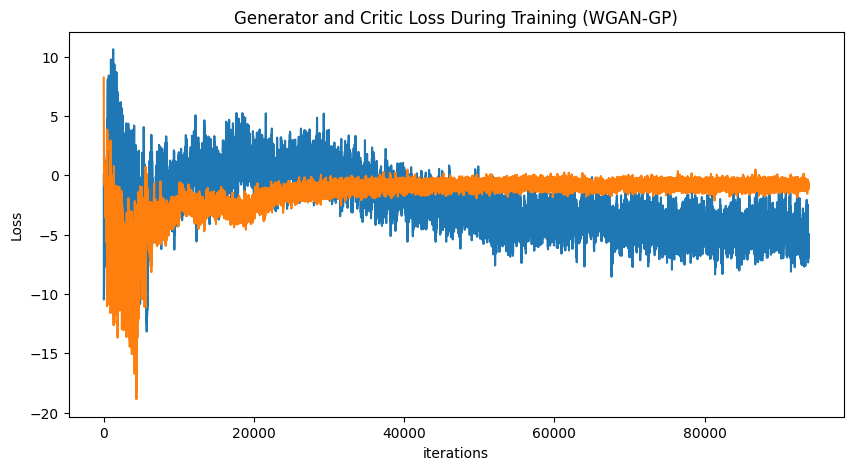

In [26]:
plot_loss(losses_generator_wgangp, losses_critic_wgangp, "Generator and Critic Loss During Training (WGAN-GP)")

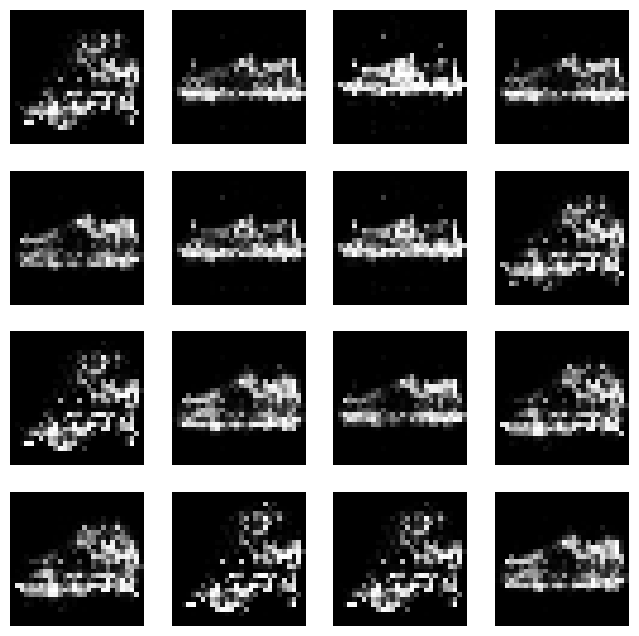

In [27]:
generate_images(conditional_generator, label=5, config=config, device=device)
